In [1]:
%reload_ext autoreload
%autoreload 2

# Load the data

In [2]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]

# Load results

In [3]:
import json

with open("../results/infoPerfo_v3.json", "r") as f:
    decoding_results = json.load(f)

print(decoding_results)

{'cnn25s724wx0008f9kz0': [{'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 2}, {'decoding': 'kde_0.5', 'num_errors': 1, 'nb_intervals': 2, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 3}, {'decoding': 'kde_0.5', 'num_errors': 2, 'nb_intervals': 3, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 4}, {'decoding': 'kde_0.5', 'num_errors': 1, 'nb_intervals': 4, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 5}, {'decoding': 'kde_0.5', 'num_errors': 1, 'nb_intervals': 5, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'grid', 'num_errors': 0, 'nb_intervals': 6}, {'decoding': 'kde_0.5', 

# Get the cummulative error dict

In [4]:
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

# Initialize the dictionary with the new structure
err_rates_dict = {pair: [{}, 0] for pair in pairs_to_process}

# Assuming md and decoding_results are defined
for index, row in md.iterrows():
    if (row["distance"], row["rounds"]) not in pairs_to_process:
        continue
    
    decoding_result = decoding_results[row["job_id"]]
    # Add the shots to the total
    err_rates_dict[(row["distance"], row["rounds"])][1] += row["shots"]
    
    # Add the errors to the dictionary, now considering nb_intervals
    for decoding_entry in decoding_result:
        decoding = decoding_entry["decoding"]
        nb_intervals = decoding_entry["nb_intervals"]
        num_errors = decoding_entry["num_errors"]
        
        if decoding not in err_rates_dict[(row["distance"], row["rounds"])][0]:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding] = {nb_intervals: num_errors}
        else:
            if nb_intervals not in err_rates_dict[(row["distance"], row["rounds"])][0][decoding]:
                err_rates_dict[(row["distance"], row["rounds"])][0][decoding][nb_intervals] = num_errors
            else:
                err_rates_dict[(row["distance"], row["rounds"])][0][decoding][nb_intervals] += num_errors

print(err_rates_dict)


{(10, 10): [{'grid': {2: 233, 3: 191, 4: 178, 5: 170, 6: 159, 7: 153, 8: 140, 9: 134, 10: 134, 11: 126, 12: 124, 13: 123, 15: 122, 17: 121, 18: 121, 20: 125, 23: 125, 25: 120, 28: 118, 31: 116, 35: 111, 39: 111, 43: 112, 48: 116, 53: 115, 59: 118, 66: 116, 73: 114, 81: 116, 90: 120, 100: 116, 111: 117, 124: 114, 137: 115, 153: 114, 170: 112, 189: 114, 210: 114, 233: 112, 259: 114, 288: 112, 320: 115, 356: 113, 395: 112, 439: 112, 488: 115, 543: 112, 604: 114, 671: 114, 746: 112, 829: 115, 921: 115, 1024: 115}, 'kde_0.5': {2: 246, 3: 240, 4: 223, 5: 228, 6: 222, 7: 209, 8: 199, 9: 196, 10: 196, 11: 186, 12: 175, 13: 167, 15: 152, 17: 151, 18: 152, 20: 152, 23: 143, 25: 142, 28: 146, 31: 144, 35: 136, 39: 139, 43: 129, 48: 128, 53: 123, 59: 129, 66: 126, 73: 122, 81: 122, 90: 121, 100: 117, 111: 116, 124: 116, 137: 113, 153: 114, 170: 115, 189: 113, 210: 115, 233: 112, 259: 113, 288: 112, 320: 113, 356: 113, 395: 113, 439: 113, 488: 114, 543: 114, 604: 114, 671: 111, 746: 113, 829: 112, 

# Append the nb_intervals = -1 to the end of the dict

In [5]:

with open("../results/softInfo_vs_informed.json", "r") as f:
    decoding_results_no_int = json.load(f)

for index, row in md.iterrows():
    if (row["distance"], row["rounds"]) not in pairs_to_process:
        continue
    
    decoding_result = decoding_results_no_int[row["job_id"]]
    
    # Add the errors to the dictionary, now considering nb_intervals
    for decoding_entry in decoding_result:
        decoding = decoding_entry["decoding"]
        if decoding not in ["grid", "kde_0.5"]:
            continue
        num_errors = decoding_entry["num_errors"]
        if -1 not in err_rates_dict[(row["distance"], row["rounds"])][0][decoding]:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding][-1] = num_errors
        else:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding][-1] += num_errors

print(err_rates_dict)

{(10, 10): [{'grid': {2: 233, 3: 191, 4: 178, 5: 170, 6: 159, 7: 153, 8: 140, 9: 134, 10: 134, 11: 126, 12: 124, 13: 123, 15: 122, 17: 121, 18: 121, 20: 125, 23: 125, 25: 120, 28: 118, 31: 116, 35: 111, 39: 111, 43: 112, 48: 116, 53: 115, 59: 118, 66: 116, 73: 114, 81: 116, 90: 120, 100: 116, 111: 117, 124: 114, 137: 115, 153: 114, 170: 112, 189: 114, 210: 114, 233: 112, 259: 114, 288: 112, 320: 115, 356: 113, 395: 112, 439: 112, 488: 115, 543: 112, 604: 114, 671: 114, 746: 112, 829: 115, 921: 115, 1024: 115, -1: 115}, 'kde_0.5': {2: 246, 3: 240, 4: 223, 5: 228, 6: 222, 7: 209, 8: 199, 9: 196, 10: 196, 11: 186, 12: 175, 13: 167, 15: 152, 17: 151, 18: 152, 20: 152, 23: 143, 25: 142, 28: 146, 31: 144, 35: 136, 39: 139, 43: 129, 48: 128, 53: 123, 59: 129, 66: 126, 73: 122, 81: 122, 90: 121, 100: 117, 111: 116, 124: 116, 137: 113, 153: 114, 170: 115, 189: 113, 210: 115, 233: 112, 259: 113, 288: 112, 320: 113, 356: 113, 395: 113, 439: 113, 488: 114, 543: 114, 604: 114, 671: 111, 746: 113, 8

# Plot the infoPerfo tradeoff

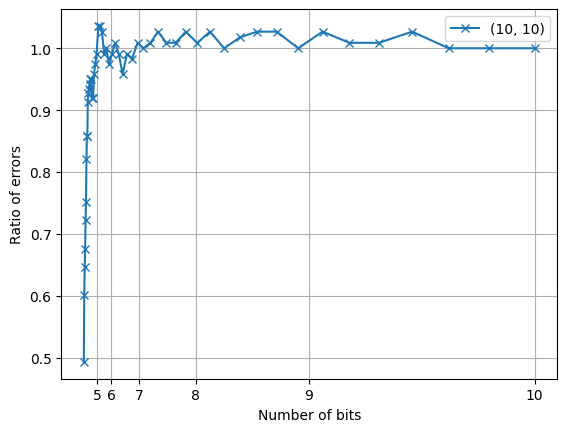

In [6]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, _) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_grid = list(err_rate_dict["grid"].keys())
    errs_grid = list(err_rate_dict["grid"].values())

    ratios = [errs_grid[-1]/(err + 1e-8) for err in errs_grid[:-1]]
    bits = bits_grid[:-1]
    
    plt.plot(bits, ratios, label=f"{pair}", marker="x")

# plt.xscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Ratio of errors")
plt.legend()
plt.grid()


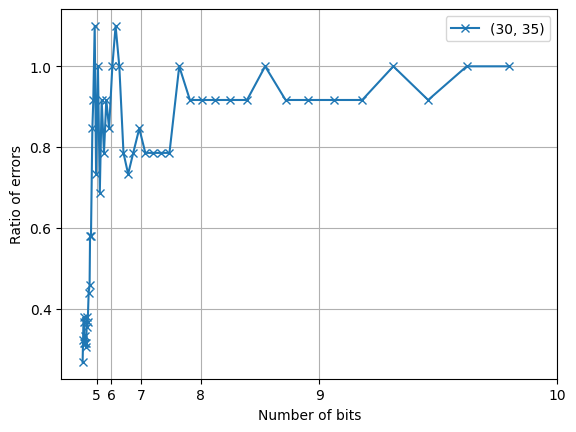

In [7]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, _) in err_rates_dict.items():
    i += 1
    if i != 3:
        continue

    bits_kde = list(err_rate_dict["kde_0.5"].keys())
    errs_kde = list(err_rate_dict["kde_0.5"].values())

    ratios = [errs_kde[-1]/(err + 1e-8) for err in errs_kde[:-1]]
    bits = bits_kde[:-1]
    
    plt.plot(bits, ratios, label=f"{pair}", marker="x")

# plt.xscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Ratio of errors")
plt.legend()
plt.grid()


# Plot the error rates instead of ratio

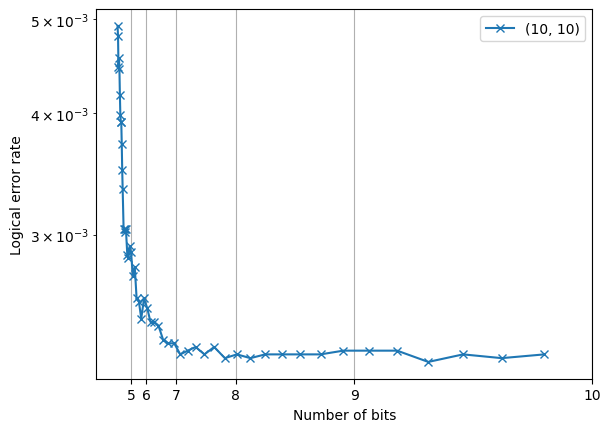

In [8]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, shots) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_kde = list(err_rate_dict["kde_0.5"].keys())
    errs_kde = list(err_rate_dict["kde_0.5"].values())


    bits = bits_kde[:-1]
    err_rates = [err/shots for err in errs_kde][:-1]
    
    plt.plot(bits, err_rates, label=f"{pair}", marker="x")

# plt.xscale("log")
plt.yscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
# plt.yticks(ticks=[0.001, 0.003, 0.006, 0.01], labels=["0.1%", "0.3%", "0.6%", "1%"])

plt.xlabel("Number of bits")
plt.ylabel("Logical error rate")
plt.legend()
plt.grid()


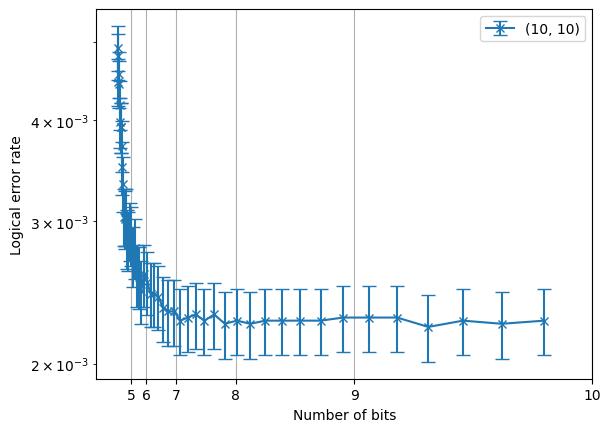

In [9]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, shots) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_kde = list(err_rate_dict["kde_0.5"].keys())
    errs_kde = list(err_rate_dict["kde_0.5"].values())

    bits = bits_kde[:-1]
    err_rates = [err/shots for err in errs_kde][:-1]

    # Calculate standard errors for the error rates
    standard_errors = [np.sqrt((rate * (1 - rate)) / shots) for rate in err_rates]
    standard_errors = [np.sqrt((rate) / shots) for rate in err_rates]
    
    # Plot with error bars
    plt.errorbar(bits, err_rates, yerr=standard_errors, label=f"{pair}", fmt='x-', capsize=5)

plt.yscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Logical error rate")
plt.legend()
plt.grid(True)
plt.show()


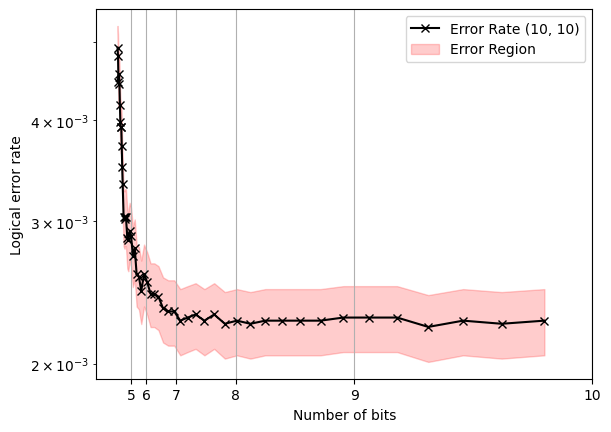

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

err_rates_informed = []
err_rates_kde = []

i = 0
for pair, (err_rate_dict, shots) in err_rates_dict.items():
    i += 1
    if i != 1:
        continue

    bits_kde = list(err_rate_dict["kde_0.5"].keys())
    errs_kde = list(err_rate_dict["kde_0.5"].values())

    bits = bits_kde[:-1]
    err_rates = [err/shots for err in errs_kde][:-1]
    
    standard_errors = [np.sqrt(rate / shots) for rate in err_rates]
    
    # Upper and lower bounds for the error region
    err_rates_upper = [rate + error for rate, error in zip(err_rates, standard_errors)]
    err_rates_lower = [max(rate - error, 1e-10) for rate, error in zip(err_rates, standard_errors)]  # Avoid negative values

    # Plot the central line
    line = plt.plot(bits, err_rates, 'x-', color='black', label=f"Error Rate {pair}")

    # Plot the error region with alpha for transparency
    plt.fill_between(bits, err_rates_lower, err_rates_upper, color='red', alpha=0.2)

# Create a patch for the error region to add to the legend
error_patch = mpatches.Patch(color='red', alpha=0.2, label='Error Region')

# Add both the line and the error patch to the legend
plt.legend(handles=[line[0], error_patch])

plt.yscale("log")
plt.xticks([2**i for i in range(5, 11)], labels=[f"{i}" for i in range(5, 11)])
plt.xlabel("Number of bits")
plt.ylabel("Logical error rate")
plt.grid(True)
plt.show()
